In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
df = pd.read_csv("credit_history_train.csv")

In [38]:
df.columns

Index(['ID', 'CREDIT', 'GENDER', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_FEB',
       'PAY_JAN', 'PAY_DEC', 'BILL_AMT_FEB', 'BILL_AMT_JAN', 'BILL_AMT_DEC',
       'PAY_AMT_FEB', 'PAY_AMT_JAN', 'PAY_AMT_DEC', 'DEFAULT_MAR'],
      dtype='object')

In [39]:
df_default=df[df.DEFAULT_MAR==1]
df_no_default=df[df.DEFAULT_MAR==0]

In [60]:
dataset = pd.concat([df_no_default.sample(round(len(df_default)*0.5/0.5)),df_default])
dataset["DEFAULT_MAR"].value_counts()

1    3377
0    3377
Name: DEFAULT_MAR, dtype: int64

In [61]:
categorical_columns = ['GENDER', 'EDUCATION', 'MARRIAGE','PAY_FEB',
       'PAY_JAN', 'PAY_DEC']
numerical_columns = ['CREDIT', 'AGE', 'BILL_AMT_FEB', 'BILL_AMT_JAN', 'BILL_AMT_DEC',
       'PAY_AMT_FEB', 'PAY_AMT_JAN', 'PAY_AMT_DEC']
outputs = ['DEFAULT_MAR']

In [62]:
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

In [63]:
gen = dataset['GENDER'].cat.codes.values
edu = dataset['EDUCATION'].cat.codes.values
marr = dataset['MARRIAGE'].cat.codes.values
pay_f = dataset['PAY_FEB'].cat.codes.values
pay_j = dataset['PAY_JAN'].cat.codes.values
pay_d = dataset['PAY_DEC'].cat.codes.values

categorical_data = np.stack([gen,edu,marr,pay_f,pay_j,pay_d], 1)

In [64]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

In [65]:
numerical_data = np.stack([dataset[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:5]

tensor([[ 2.3000e+05,  2.9000e+01, -5.0000e+00, -5.0000e+00,  2.9690e+03,
          0.0000e+00,  2.9740e+03,  3.4250e+03],
        [ 2.0000e+04,  2.4000e+01,  2.5220e+03,  3.9000e+02,  0.0000e+00,
          3.9000e+02,  0.0000e+00,  7.8000e+02],
        [ 1.6000e+05,  4.0000e+01,  1.4798e+05,  1.4989e+05,  1.2428e+05,
          6.0000e+03,  4.3700e+03,  4.4000e+03],
        [ 5.0000e+04,  5.4000e+01,  4.8403e+04,  4.8119e+04,  4.3590e+04,
          2.0200e+03,  3.1280e+03,  1.0000e+03],
        [ 5.0000e+04,  3.5000e+01,  4.8829e+04,  4.9789e+04,  1.9726e+04,
          2.0460e+03,  3.0000e+03,  1.5000e+03]])

In [66]:
outputs = torch.tensor(dataset[outputs].values).flatten()
outputs[:5]

tensor([0, 0, 0, 0, 0])

In [47]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(2, 1), (5, 3), (3, 2), (7, 4), (7, 4), (7, 4)]


In [72]:
type(categorical_data)

torch.Tensor

In [99]:
import random
random.seed(42)
test_index_list=(random.sample(range(len(outputs)), int(total_records * .2)))
train_index_list = [i for i in range(len(outputs)) if i not in test_index_list]

In [100]:
categorical_train_data = categorical_data[train_index_list]
categorical_test_data = categorical_data[test_index_list]
numerical_train_data = numerical_data[train_index_list]
numerical_test_data = numerical_data[test_index_list]
train_outputs = outputs[train_index_list]
test_outputs = outputs[test_index_list]

In [101]:
print(len(categorical_train_data))
print(len(numerical_train_data))
print(len(train_outputs))

print(len(categorical_test_data))
print(len(numerical_test_data))
print(len(test_outputs))

5404
5404
5404
1350
1350
1350


In [102]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [103]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.4)

In [104]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [105]:
epochs = 300
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.84499681
epoch:  26 loss: 0.64089239
epoch:  51 loss: 0.63474852
epoch:  76 loss: 0.62126613
epoch: 101 loss: 0.61876106
epoch: 126 loss: 0.61176306
epoch: 151 loss: 0.60854071
epoch: 176 loss: 0.60768241
epoch: 201 loss: 0.60505652
epoch: 226 loss: 0.60664809
epoch: 251 loss: 0.60202533
epoch: 276 loss: 0.60082847
epoch: 300 loss: 0.6027570963


Text(0.5, 0, 'epoch')

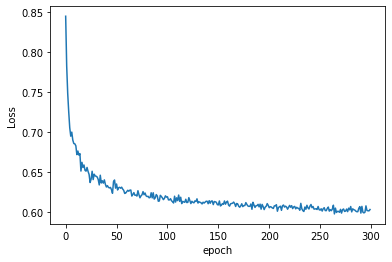

In [106]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [107]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.59656262


In [108]:
y_val = np.argmax(y_val, axis=1)

In [109]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score

print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))

[[527 141]
 [282 400]]
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       668
           1       0.74      0.59      0.65       682

    accuracy                           0.69      1350
   macro avg       0.70      0.69      0.68      1350
weighted avg       0.70      0.69      0.68      1350

0.6866666666666666


In [110]:
roc_auc_score(test_outputs, y_val)

0.6877162098091207

In [113]:
df_test=pd.read_csv("credit_history_test.csv")
for category in categorical_columns:
    df_test[category] = df_test[category].astype('category')

In [114]:
gen = df_test['GENDER'].cat.codes.values
edu = df_test['EDUCATION'].cat.codes.values
marr = df_test['MARRIAGE'].cat.codes.values
pay_f = df_test['PAY_FEB'].cat.codes.values
pay_j = df_test['PAY_JAN'].cat.codes.values
pay_d = df_test['PAY_DEC'].cat.codes.values

categorical_data = np.stack([gen,edu,marr,pay_f,pay_j,pay_d], 1)

In [115]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

In [117]:
numerical_data = np.stack([df_test[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:5]

tensor([[5.0000e+04, 2.2000e+01, 2.4763e+04, 3.3542e+04, 3.0455e+04, 1.0000e+04,
         1.1750e+03, 2.0000e+03],
        [8.0000e+04, 2.4000e+01, 7.5356e+04, 7.8236e+04, 7.7700e+04, 5.0000e+03,
         4.1760e+03, 4.0000e+03],
        [9.0000e+04, 2.8000e+01, 2.4657e+04, 2.5743e+04, 2.6406e+04, 1.5000e+03,
         1.5000e+03, 1.5080e+03],
        [5.0000e+04, 2.7000e+01, 4.9200e+02, 4.9200e+02, 4.9200e+02, 4.9300e+02,
         4.9300e+02, 4.9300e+02],
        [2.7000e+05, 3.2000e+01, 1.1632e+05, 1.1910e+05, 1.2225e+05, 6.5000e+03,
         6.8430e+03, 6.2840e+03]])

In [121]:
with torch.no_grad():
    y_val = model(categorical_data, numerical_data)

In [122]:
y_val = np.argmax(y_val, axis=1)

In [124]:
sum(y_val)

tensor(6418)

In [127]:
df.head()

,ID,CREDIT,GENDER,EDUCATION,MARRIAGE,AGE,PAY_FEB,PAY_JAN,PAY_DEC,BILL_AMT_FEB,BILL_AMT_JAN,BILL_AMT_DEC,PAY_AMT_FEB,PAY_AMT_JAN,PAY_AMT_DEC,DEFAULT_MAR
0,1,20000,Female,Post Graduate,Married,24,2,2,-1,3913,3102,689,0,689,0,1
1,2,120000,Female,Post Graduate,Single,26,-1,2,-1,2682,1725,2682,0,1000,1000,1
2,3,90000,Female,Post Graduate,Single,34,-1,-1,-1,29239,14027,13559,1518,1500,1000,0
3,4,50000,Female,Post Graduate,Married,37,-1,-1,-1,46990,48233,49291,2000,2019,1200,0
4,5,50000,Male,Post Graduate,Married,57,-1,-1,-1,8617,5670,35835,2000,36681,10000,0


(array([1.3689e+04, 1.1320e+03, 1.5900e+02, 1.8000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ -34041.,  135772.,  305585.,  475398.,  645211.,  815024.,
         984837., 1154650., 1324463., 1494276., 1664089.]),
 <BarContainer object of 10 artists>)

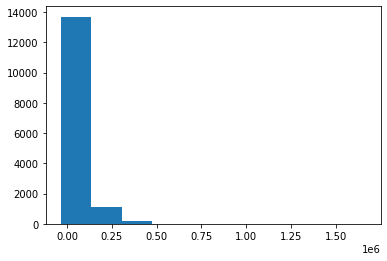

In [130]:
plt.hist(df["BILL_AMT_DEC"])

In [135]:
from scipy.stats import shapiro
stat, p = shapiro(df["PAY_AMT_JAN"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.178, p=0.000
Sample does not look Gaussian (reject H0)
